<div align="center">

# Обучение ансамбля моделей

</div>

---


## Ансамблевые методы (Ensemble Methods)

### Суть идеи

Ансамблевые методы объединяют несколько классификаторов в **метаклассификатор**, который:

* Обобщает лучше, чем каждый классификатор по отдельности.
* Дает более точный и надежный прогноз (аналог совета группы экспертов).

Пример:
Предсказания 10 экспертов можно объединить стратегически, чтобы итоговое решение было точнее, чем любое из отдельных.

### Основные подходы

Ансамбли можно строить:

* **Из разных алгоритмов классификации** — деревья решений, SVM, логистическая регрессия и др.
* **Из одного алгоритма**, но обученного на разных подмножествах данных
  (пример: **Случайный лес** — ensemble из деревьев решений).

### Мажоритарное голосование

**Majority voting (абсолютное большинство)**:

* Выбираем метку класса, за которую проголосовало более 50% классификаторов.
* Применяется к **бинарной классификации**.

**Plurality voting (относительное большинство)**:

* Используется для многоклассовой классификации.
* Выбирается метка с наибольшим количеством голосов, даже если < 50%.

**Формула для выбора метки:**

$$
y = \text{mode}\{C_1(x), C_2(x), \dots, C_t(x)\}
$$

где $C_i(x)$ — предсказание i-го классификатора.


### Почему ансамбли лучше

Если:

* Каждый из $n$ базовых классификаторов имеет одинаковую частоту ошибок $E$,
* Ошибки классификаторов независимы и некоррелированы,
  то вероятность ошибки ансамбля можно выразить через биномиальное распределение:

$$
P(y >= k) = \sum_k^{n} \binom{n}{k} \varepsilon^k (1 - \varepsilon)^{n-k} = \varepsilon_{\text{ensembles}}
$$


где:

* $\binom{n}{k}$ — **биномиальный коэффициент** (число способов выбрать k элементов из n без учета порядка):

$$
\binom{n}{k} = \frac{n!}{(n-k)! \cdot k!}
$$


### Ключевые термины

* **Mode** — мода, наиболее часто встречающаяся метка класса.
* **Binomial coefficient** — число сочетаний из $n$ по $k$, обозначается $\binom{n}{k}$.
* **Combinatorial number** — другое название биномиального коэффициента.

---

<div align="center">

# Объединение классификаторов по методу большинства голосов

</div>



* Когда мы оцениваем качество классификатора метриками, которые используют вероятности (например, **ROC AUC**), модель должна уметь возвращать **оценку вероятности** для каждого класса.
* В `scikit-learn` для этого используется метод **`.predict_proba()`** (если он реализован у данного алгоритма).


#### **Как деревья решений вычисляют вероятности**

* При обучении дерево для каждого **узла** запоминает распределение классов среди обучающих объектов, которые туда попали.
  Пример: в узле оказалось 10 объектов: 7 класса A, 3 класса B → вектор частот = $[7, 3]$.
* Этот вектор **нормализуют** (делят на сумму элементов), чтобы получилось что-то, похожее на вероятности: $[0.7, 0.3]$.
* Для нового объекта вероятность класса = нормализованное распределение в **листе**, куда он попал.


#### **Как это делает k-NN**

* Аналогично: берём k ближайших соседей, считаем долю каждого класса среди них.
* Нормализуем, чтобы сумма была 1.


#### **Главная мысль**

* Эти значения **не являются “настоящими” вероятностями** в строгом статистическом смысле (т.е. они не получены из параметрической функции распределения масс, как в логистической регрессии).
* Это просто **относительные частоты** классов среди обучающих данных в соответствующей области признакового пространства.

>Хотя `.predict_proba()` в деревьях решений и k-NN возвращает числа, которые выглядят как вероятности, они имеют другую природу, и их интерпретация и калибровка могут быть важны, особенно в задачах, где важна корректность вероятностных оценок.



In [46]:
# DataSet Iris, выберем только два признака, ширину чашелистика
# и длину лепестка, чтобы сделать задачу классификации сложной
# Будем классифицировать только примеры цветков из класса
# Iris-versicolor и Iris-virginica

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV

In [47]:
# Загрузка и предобработка данных 
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)

In [48]:
# Разделение данных 50 на 50
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.5,
                     random_state = 1, stratify = y)


In [49]:
# Обучим данные на трех моделях классификатора

# Логистическая регрессия
clf1 = LogisticRegression(penalty = 'l2',
                          C = 0.001,
                          solver = 'lbfgs',
                          random_state = 1)
# Дерево решений
clf2 = DecisionTreeClassifier(max_depth = 1, 
                              criterion = 'entropy', 
                              random_state = 0)
# k-ближайших соседей
clf3 = KNeighborsClassifier(n_neighbors = 1,
                            p = 2,
                            metric = 'minkowski')
# Конвейер 1
pipe_1 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf1]])
# Конвейер 3
pipe_3 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf3]])

clf_labels = ['Логистическая регрессия', 'Дерево решений', 'KNN']
print('10-кратная перекрестная проверка:\n')
for clf, label in zip([pipe_1, clf2, pipe_3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/-) {scores.std():.2f} [{label}]')

10-кратная перекрестная проверка:

ROC AUC: 0.92 (+/-) 0.15 [Логистическая регрессия]
ROC AUC: 0.87 (+/-) 0.18 [Дерево решений]
ROC AUC: 0.85 (+/-) 0.13 [KNN]


In [55]:
# Теперь объединим отдельные классификаторы для голосования
mv_clf = VotingClassifier(
    estimators=[
        ('pipeline-1', pipe_1),
        ('decisiontreeclassifier', clf2),
        ('pipe3', pipe_3)
    ],
    voting='soft'  # Для усреднение вероятностей
)
clf_labels += ['Мажоритарное голосование']
all_clf = [pipe_1, clf2, pipe_3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'+/- {scores.std():.2f} [{label}]')

ROC AUC: 0.92 +/- 0.15 [Логистическая регрессия]
ROC AUC: 0.87 +/- 0.18 [Дерево решений]
ROC AUC: 0.85 +/- 0.13 [KNN]
ROC AUC: 0.98 +/- 0.05 [Мажоритарное голосование]


Как можно видеть при 10-кратной перекрестной проверке производительность у `VotingClassifier()` выше, чем у отдельных классификаторов.

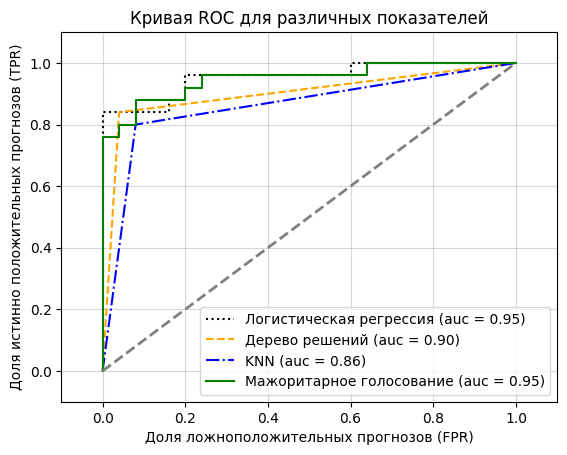

In [56]:
# Вычислим кривые ROC на тестовом наборе данных
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
        # Пусть метка положительного класса это 1
        y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                         y_score = y_pred)
        roc_auc = auc(x = fpr, y = tpr)
        plt.plot(fpr, tpr, color = clr,
                 linestyle = ls,
                 label = f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = 'gray',
         linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('Доля ложноположительных прогнозов (FPR)')
plt.ylabel('Доля истинно положительных прогнозов (TPR)')
plt.title('Кривая ROC для различных показателей')
plt.show()

На графике видно по линии **ROC** ансамблевый классификатор хорошо работает с тестовыми данными **(ROC AUC = 0.95)**, но и классификатор логистической регрессии также хорошо справляется на тестовом наборе данных, что вероятно связано с высокой дисперсией (в нашем случае чувствительностью к тому, как мы разделяем набор данных), потому что размер набора относительно небольшой.

Посколько мы выбрали только два признака, было бы интересно посмотреть на область принятия решений ансамблевого классификатора.

--- 

Стандартизовать признаки перед обучением моделей не всегда обязательно, особенно если модель или конвейер уже это делает автоматически (как логистическая регрессия или k-NN).

Но мы всё же выполним стандартизацию данных, чтобы у деревьев решений (которые сами не требуют стандартизации) области решений были на одном масштабе — это поможет лучше визуализировать и понять, как модель принимает решения.


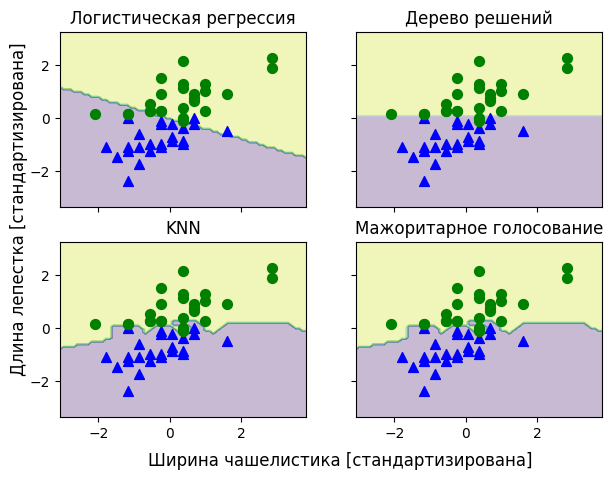

In [57]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 2, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (7, 5))

for idx, clf, tt in zip (product([0, 1], [0, 1]),
                         all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c = 'blue',
                                  marker = '^',
                                  s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c = 'green',
                                  marker = 'o',
                                  s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s = 'Ширина чашелистика [стандартизирована]',
         ha = 'center', va = 'center', fontsize = 12)
plt.text(-12.5, 4.5,
         s = 'Длина лепестка [стандартизирована]',
         ha = 'center', va = 'center',
         fontsize = 12, rotation = 90)
plt.show()

Области решений **ансамбля** формируются как комбинация областей отдельных классификаторов. Граница большинства голосов похожа на «ступенчатое» разделение **дерева решений**, ориентированное почти по оси Y при ширине чашелистика около 1. При этом нелинейность, добавленная **k-ближайшими соседями**, делает итоговую границу более сложной и гибкой.

In [58]:
# Доступ к отдельным параметрам внутри GridSearchCV
mv_clf.get_params()

{'estimators': [('pipeline-1',
   Pipeline(steps=[('sc', StandardScaler()),
                   ['clf', LogisticRegression(C=0.001, random_state=1)]])),
  ('decisiontreeclassifier',
   DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)),
  ('pipe3',
   Pipeline(steps=[('sc', StandardScaler()),
                   ['clf', KNeighborsClassifier(n_neighbors=1)]]))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipe3': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input':

In [59]:
# Для демонстрации настроим поиск по сетке
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator = mv_clf,
                    param_grid = params,
                    cv = 10,
                    scoring = 'roc_auc')
grid.fit(X_train, y_train)

,estimator,VotingClassif...voting='soft')
,param_grid,"{'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [60]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [61]:
print(f'Лучшие параметры: {grid.best_params_}')

Лучшие параметры: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [62]:
print(f'ROC AUC : {grid.best_score_:.2f}')

ROC AUC : 0.98


Как можно заметить, мы получаем наилучшие результаты перекрестной проверки, когда выбираем более низкую степень регуляризации `(C = 0.001)`, а глубина дерева видимо не влияет на производительность, вероятно обрубка дерева достаточно для разделения данных.
Использовать тестовый набор данных более одного раза для оценки модели - плохая практика, так что оценивать производительность обобщения настроенных гиперпараметров не станем.